# Classifiers using neuro-imaging data

In [1]:
import pandas as pd
import numpy as np
from numpy import random, arange
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder

# Import relevant sklearn classes related to machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC, SVR, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

# Import relevant sklearn class/function related to evaluation
import sklearn.metrics
from imblearn.under_sampling import RandomUnderSampler

#Smote oversampling 
import smote_variants as sv

## Data Pre-Processing

In [39]:

img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [40]:
img_adni2.replace("scmri", "sc", inplace=True)
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)
adni2 = img_adni2.loc[img_adni2['VISCODE2'] == "sc"]
adni3 = img_adni3.loc[img_adni3['VISCODE2'] == "sc"]
adni1 = img_adni1.loc[img_adni1['VISCODE'] == 'bl']

In [41]:
#CVs = []
SVs = []
#SAs = []
#TSs = []
TAs = []
#HSs = []

for col in adni2.columns:
    
    #if col.endswith('CV'):
        #CVs.append(col)
    if col.endswith('SV'):
        SVs.append(col)
    """
    if col.endswith('SA'):
        SAs.append(col)
    if col.endswith('TS'):
        TSs.append(col)
    if col.endswith('HS'):
        HSs.append(col)
    """
    if col.endswith('TA'):
        TAs.append(col)

TAs.append("RID")
TAs2 = TAs.copy()
TAs2.append("VISCODE")
TAs.append("VISCODE2")


In [42]:
dxbl_subset = dx.loc[:,["VISCODE", "VISCODE2", "RID", "DXCHANGE","DXCURREN","DIAGNOSIS", "PTID"]].copy()
imgdx2 = pd.merge(adni2.loc[:,TAs].copy(), dxbl_subset, on=["RID", "VISCODE2"])
imgdx3 = pd.merge(adni3.loc[:,TAs].copy(), dxbl_subset, on=["RID", "VISCODE2"])
imgdx1 = pd.merge(adni1.loc[:,TAs2].copy(), dxbl_subset, on=["RID", "VISCODE"])

In [43]:
imgdx2["PTID"].append(imgdx3['PTID'].append(imgdx1['PTID'])).nunique()

1598

In [44]:

imgdx2.loc[(imgdx2["DXCHANGE"] == 1) | (imgdx2["DXCHANGE"] == 4) |(imgdx2["DXCHANGE"] == 6), 'DXCHANGE'] = 1
imgdx2.loc[(imgdx2["DXCHANGE"] == 2) | (imgdx2["DXCHANGE"] == 5) |(imgdx2["DXCHANGE"] == 7), 'DXCHANGE'] = 2
imgdx2.loc[(imgdx2["DXCHANGE"] == 3) | (imgdx2["DXCHANGE"] == 8) |(imgdx2["DXCHANGE"] == 9), 'DXCHANGE'] = 3


In [45]:
imgdx1

,ST102TA,ST103TA,ST104TA,ST105TA,ST106TA,ST107TA,ST108TA,ST109TA,ST110TA,ST111TA,...,ST97TA,ST98TA,ST99TA,RID,VISCODE,VISCODE2,DXCHANGE,DXCURREN,DIAGNOSIS,PTID
0,2.187,2.617,2.357,2.301,2.346,1.492,1.711,2.335,2.228,2.147,...,1.889,2.201,2.573,15,bl,bl,NaN,1.0,NaN,100_S_0015
1,2.423,2.960,2.378,2.499,2.363,1.612,2.033,2.574,2.604,2.325,...,1.901,2.387,2.788,86,bl,bl,NaN,1.0,NaN,136_S_0086
2,2.287,2.536,2.303,2.881,2.305,1.463,1.909,2.858,2.382,2.248,...,1.988,2.414,2.740,184,bl,bl,NaN,1.0,NaN,136_S_0184
3,2.004,2.372,2.294,2.168,2.018,1.713,1.672,1.991,2.108,1.898,...,1.809,2.168,2.139,187,bl,bl,NaN,2.0,NaN,032_S_0187
4,1.979,1.897,2.244,2.272,2.085,1.327,1.784,2.132,2.196,1.946,...,1.764,2.063,2.379,190,bl,bl,NaN,3.0,NaN,100_S_0190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2.308,2.118,2.485,2.508,2.433,1.776,1.954,2.403,2.412,2.260,...,2.129,2.345,2.736,1326,bl,bl,NaN,2.0,NaN,016_S_1326
108,2.232,2.753,2.544,2.412,2.324,1.789,1.891,2.445,2.306,2.172,...,2.067,2.597,2.570,1331,bl,bl,NaN,2.0,NaN,051_S_1331
109,2.058,2.255,2.191,2.166,2.209,1.499,1.779,2.412,1.991,2.218,...,1.814,2.419,2.642,1337,bl,bl,NaN,3.0,NaN,130_S_1337
110,2.347,2.445,2.550,2.475,2.165,1.961,1.833,2.221,2.201,2.169,...,2.040,2.335,2.768,1338,bl,bl,NaN,2.0,NaN,051_S_1338


In [46]:
imgdx1.drop(["VISCODE", "VISCODE2", "PTID", "RID"], inplace=True, axis=1)
imgdx2.drop(["VISCODE", "VISCODE2", "PTID", "RID"], inplace=True, axis=1)
imgdx3.drop(["VISCODE", "VISCODE2", "PTID", "RID"], inplace=True, axis=1)

img = imgdx1.append(imgdx2.append(imgdx3))

In [47]:
img['DIAGNOSIS'] = img['DIAGNOSIS'].fillna(img['DXCHANGE'])
img['DIAGNOSIS'] = img['DIAGNOSIS'].fillna(img['DXCURREN'])
img.drop(['DXCURREN', 'DXCHANGE'], axis=1, inplace=True)

In [48]:
img.columns

Index(['ST102TA', 'ST103TA', 'ST104TA', 'ST105TA', 'ST106TA', 'ST107TA',
       'ST108TA', 'ST109TA', 'ST110TA', 'ST111TA', 'ST113TA', 'ST114TA',
       'ST115TA', 'ST116TA', 'ST117TA', 'ST118TA', 'ST119TA', 'ST121TA',
       'ST129TA', 'ST130TA', 'ST13TA', 'ST14TA', 'ST15TA', 'ST23TA', 'ST24TA',
       'ST25TA', 'ST26TA', 'ST31TA', 'ST32TA', 'ST34TA', 'ST35TA', 'ST36TA',
       'ST38TA', 'ST39TA', 'ST40TA', 'ST43TA', 'ST44TA', 'ST45TA', 'ST46TA',
       'ST47TA', 'ST48TA', 'ST49TA', 'ST50TA', 'ST51TA', 'ST52TA', 'ST54TA',
       'ST55TA', 'ST56TA', 'ST57TA', 'ST58TA', 'ST59TA', 'ST60TA', 'ST62TA',
       'ST72TA', 'ST73TA', 'ST74TA', 'ST82TA', 'ST83TA', 'ST84TA', 'ST85TA',
       'ST90TA', 'ST91TA', 'ST93TA', 'ST94TA', 'ST95TA', 'ST97TA', 'ST98TA',
       'ST99TA', 'DIAGNOSIS'],
      dtype='object')

In [49]:

data = img
data_sane = data[data['DIAGNOSIS'] !=3].mean(axis=0)
stddev_sane = data[data['DIAGNOSIS'] !=3].std(axis=0)
data_alz = data[data['DIAGNOSIS'] == 3].mean(axis=0)

In [120]:
data_sane - data_alz

ST102TA      0.054250
ST103TA      0.242794
ST104TA      0.086035
ST105TA      0.094299
ST106TA      0.056793
               ...   
ST95TA       0.093075
ST97TA       0.072315
ST98TA       0.059556
ST99TA       0.203466
DIAGNOSIS   -1.522207
Length: 69, dtype: float64

## Alzheimer's classifier

Here, we wish to creater a classifier that is able to distinguish patients which have dementia/alzheimer's from patients that either have MCI or do not have any problem.
This classifier uses cross sectional brain imaging data.

### Feature selection

<Axes: xlabel='DIAGNOSIS', ylabel='Count'>

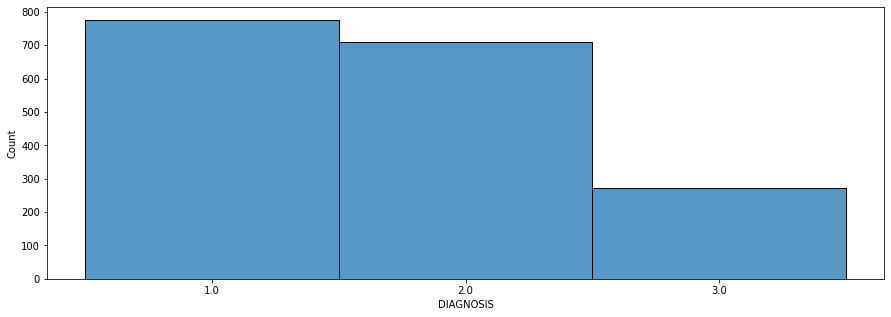

In [121]:
sns.histplot(img['DIAGNOSIS'].astype(str))

In [124]:
img.dropna(inplace=True)
img_sub = img[~(img["DIAGNOSIS"] == 2)]
Y = img_sub['DIAGNOSIS']
X = img_sub.drop(['DIAGNOSIS'], axis=1)
Y[Y == 1] = 0
Y[Y == 3] = 1


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


### Model training

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, train_size=0.6)

In [127]:

dataset= {'data': np.array(X_train),
          'target': np.array(y_train),
          'name': 'diagnosis'}

classifiers = [('sklearn.ensemble', 'GradientBoostingClassifier', {}),
              ('sklearn.ensemble', 'RandomForestClassifier', {}),
              ('sklearn.neural_network', 'MLPClassifier', {}),
              ('sklearn.tree', 'DecisionTreeClassifier', {})]

oversamplers = sv.queries.get_all_oversamplers(n_quickest=2)

os_params = sv.queries.generate_parameter_combinations(oversamplers,
                                                      n_max_comb=2)

# samp_obj and cl_obj contain the oversampling and classifier objects which give the
# best performance together
samp_obj, cl_obj= sv.evaluation.model_selection(dataset=dataset,
                                                oversamplers=os_params,
                                                classifiers=classifiers,
                                                validator_params={'n_splits': 2,
                                                                  'n_repeats': 1},
                                                n_jobs= 5)

print(samp_obj)
print(cl_obj)

2023-03-03 16:10:03.443700: processing dataset: diagnosis
('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
RandomForestClassifier()


In [128]:
X_train_samp, y_train_samp= samp_obj.sample(np.array(X_train),
                                np.array(y_train))

2023-03-03 16:10:30,230:INFO:polynom_fit_SMOTE_star: Running sampling via ('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
2023-03-03 16:10:30,232:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


In [84]:
rus = RandomUnderSampler(random_state=0)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train_samp, y_train_samp)

<Axes: xlabel='DIAGNOSIS', ylabel='Count'>

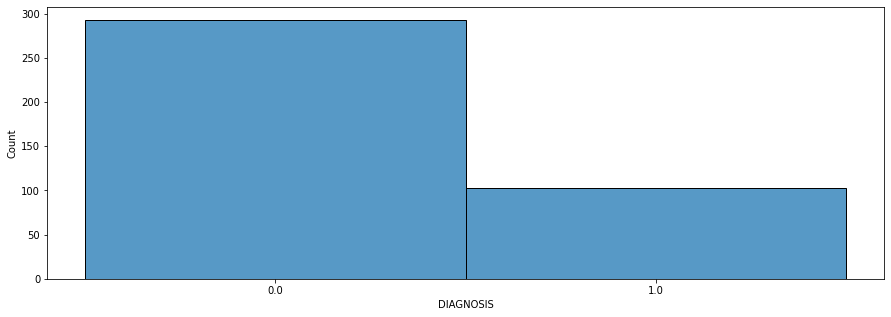

In [129]:
sns.histplot(y_test.astype(str))

In [130]:
len(y_test[y_test == 0]) / (len(y_test))

0.73989898989899

### Cross-validation

In [178]:
featureSelector = Lasso( alpha=0.005)
featureSelector.fit(X_train_resampled, y_train_resampled)

Lasso(alpha=0.005)

In [182]:
coefficients = featureSelector.coef_

In [183]:
importance = np.abs(coefficients)

In [211]:
cols = importance != 0
colNames = np.array(TAs[:68])[importance != 0]

In [192]:

X_train_resampled = X_train_resampled[:,cols]

In [193]:
models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]

In [194]:
kfold = KFold(n_splits=10)
for model in models:
    cv_results = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kfold, scoring='accuracy', n_jobs=-1)
    print(model, cv_results.sum()/10)

GradientBoostingClassifier() 0.8237327188940092
RandomForestClassifier() 0.8221198156682028
SVC() 0.8316692268305171
DecisionTreeClassifier() 0.7632360471070149
MLPClassifier() 0.7933179723502304


In [195]:
param_grid={'n_estimators':[100,500], 
            'learning_rate': [0.1,0.05,0.02],
            'max_depth':[4], 
            'min_samples_leaf':[3], 
            'max_features':[1.0] } 

kfold = KFold(n_splits=10)
rf = GradientBoostingClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_resampled, y_train_resampled)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
0.8221710189452125
{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 100}


### Evaluation

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


<Axes: >

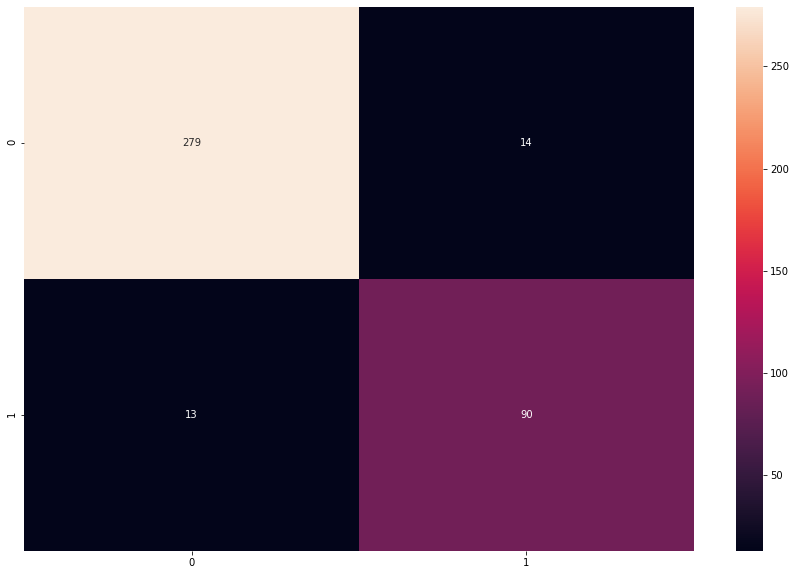

In [204]:
rf = GradientBoostingClassifier(learning_rate= 0.05, max_depth=4, max_features=1.0, min_samples_leaf=3, n_estimators=100)
rf.fit(X_train_resampled, y_train_resampled)
X_test = X_test.loc[:,cols]
results = rf.predict(X_test)
x = zip(results, y_test)

# Print the confusion matrix for the model
cf_matrix = sklearn.metrics.confusion_matrix(y_test, results)
sns.heatmap(cf_matrix, annot=True, fmt='g')

Text(0, 0.5, 'Feature Importance Score')

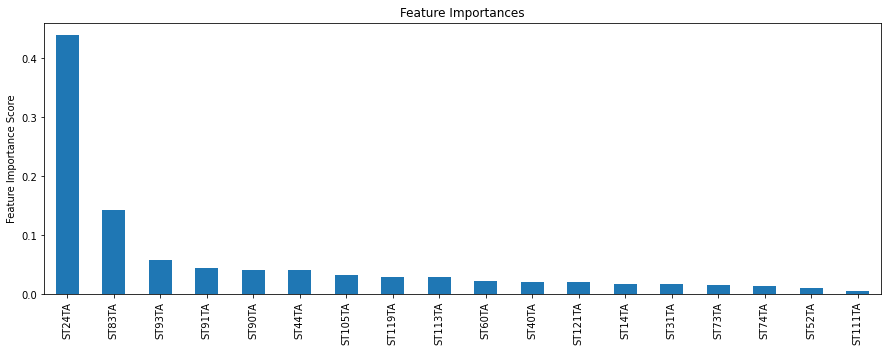

In [212]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
feat_imp = pd.Series(rf.feature_importances_, colNames).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [213]:
accuracy_score(y_test, results)

0.9318181818181818

In [214]:
balanced_accuracy_score(y_test, results)

0.9130024189005599

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


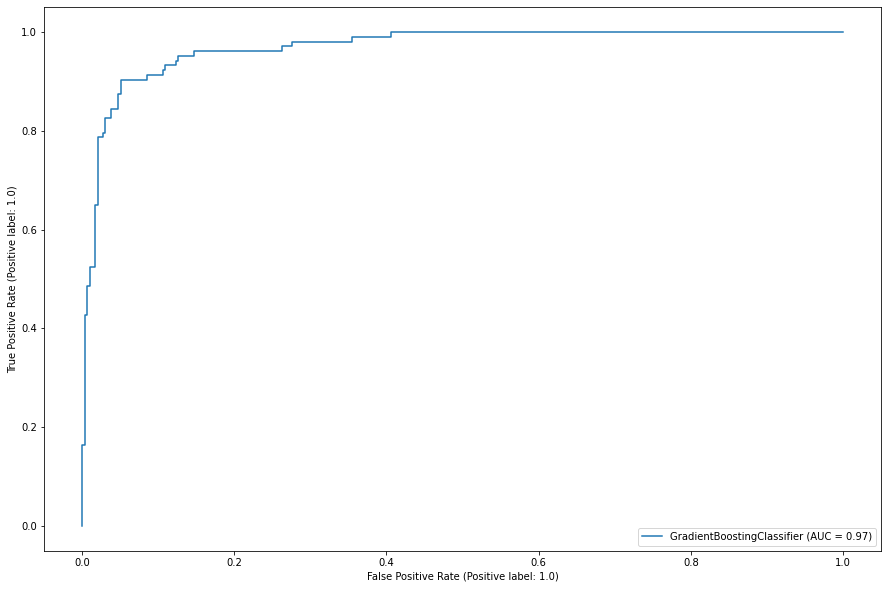

In [215]:
from sklearn.metrics import RocCurveDisplay
plt.rcParams['figure.figsize'] = [15, 10]
svc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)


## Evolution Predictor

Here we are trying to predict whether a patient currently experiencing MCI will get alzheimer's in the future from cross-sectionnal neuroimaging data. Researchers have found that having a MCI multiplies a patient's chances of developing Alzheimer's in the future. Around 20 to 20% of people with MCI develop dementia in under a year.
This is the reason why we are trying to predict the evolution. If we are able to detect whether a patient is very likely to get alzheimer's in under 2 years then it will be easier to help the patient.

In [290]:
img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [291]:
img_adni2.replace("scmri", "sc", inplace=True)
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)

In [292]:

dx.loc[(dx["DXCHANGE"] == 1) | (dx["DXCHANGE"] == 4) |(dx["DXCHANGE"] == 6), 'DXCHANGE'] = 1
dx.loc[(dx["DXCHANGE"] == 2) | (dx["DXCHANGE"] == 5) |(dx["DXCHANGE"] == 7), 'DXCHANGE'] = 2
dx.loc[(dx["DXCHANGE"] == 3) | (dx["DXCHANGE"] == 8) |(dx["DXCHANGE"] == 9), 'DXCHANGE'] = 3


In [293]:
#CVs = []
#SVs = []
#SAs = []
#TSs = []
TAs = []
#HSs = []

for col in img_adni2.columns:
    
    #if col.endswith('CV'):
        #CVs.append(col)
    #if col.endswith('SV'):
        #SVs.append(col)
    """
    if col.endswith('SA'):
        SAs.append(col)
    if col.endswith('TS'):
        TSs.append(col)
    if col.endswith('HS'):
        HSs.append(col)
    """
    if col.endswith('TA'):
        TAs.append(col)

TAs.append("RID")
TAs2 = TAs.copy()
TAs2.append("VISCODE2")
TAs.append("VISCODE")


In [294]:
img1 = img_adni1.loc[:,TAs].copy()
img2 = img_adni2.loc[:,TAs2].copy()
img3 = img_adni3.loc[:,TAs2].copy()

In [295]:
dx_info = dx.loc[:,["RID", "VISCODE", "VISCODE2", "PTID", "DXCURREN", "DXCHANGE", "DIAGNOSIS"]].copy()
img_dx_1 = pd.merge(img1, dx_info, on=['VISCODE', 'RID'])
img_dx_2 = pd.merge(img2, dx_info, on=['VISCODE2', 'RID'])
img_dx_3 = pd.merge(img3, dx_info, on=['VISCODE2', 'RID'])

In [296]:
init_1 = img_dx_1[img_dx_1['VISCODE'] == 'bl']
init_2 = img_dx_2[img_dx_2['VISCODE2'] == 'sc']
init_3 = img_dx_3[img_dx_3['VISCODE2'] == 'sc']

In [297]:
dx_m36 = dx.loc[(dx['VISCODE'] == "m36")|( dx['VISCODE2'] == "m36")]
dx_m36_diag = dx_m36.loc[:,["PTID", "DIAGNOSIS", "DXCHANGE", "DXCURREN"]]

In [298]:
dx_img1 = pd.merge(init_1, dx_m36_diag, on=["PTID"])
dx_img2 = pd.merge(init_2, dx_m36_diag, on=["PTID"])
dx_img3 = pd.merge(init_3, dx_m36_diag, on=["PTID"])

In [299]:
dx_img = dx_img1[dx_img1['DXCURREN_x'] == 2].append(dx_img2[dx_img2['DXCHANGE_x'] == 2].append(dx_img3[dx_img3['DIAGNOSIS_x'] == 2]))

In [300]:
dx_img['DIAGNOSIS_x'] = dx_img['DIAGNOSIS_x'].fillna(dx_img['DXCHANGE_x'])
dx_img['DIAGNOSIS_x'] = dx_img['DIAGNOSIS_x'].fillna(dx_img['DXCURREN_x'])

dx_img['DIAGNOSIS_y'] = dx_img['DIAGNOSIS_y'].fillna(dx_img['DXCHANGE_y'])
dx_img['DIAGNOSIS_y'] = dx_img['DIAGNOSIS_y'].fillna(dx_img['DXCURREN_y'])

dx_img.drop(["DXCHANGE_x", "DXCHANGE_y", "DXCURREN_x", "DXCURREN_y", "VISCODE", "VISCODE2", "PTID", "RID", "DIAGNOSIS_x"], axis=1, inplace=True)


<Axes: xlabel='DIAGNOSIS_y', ylabel='Count'>

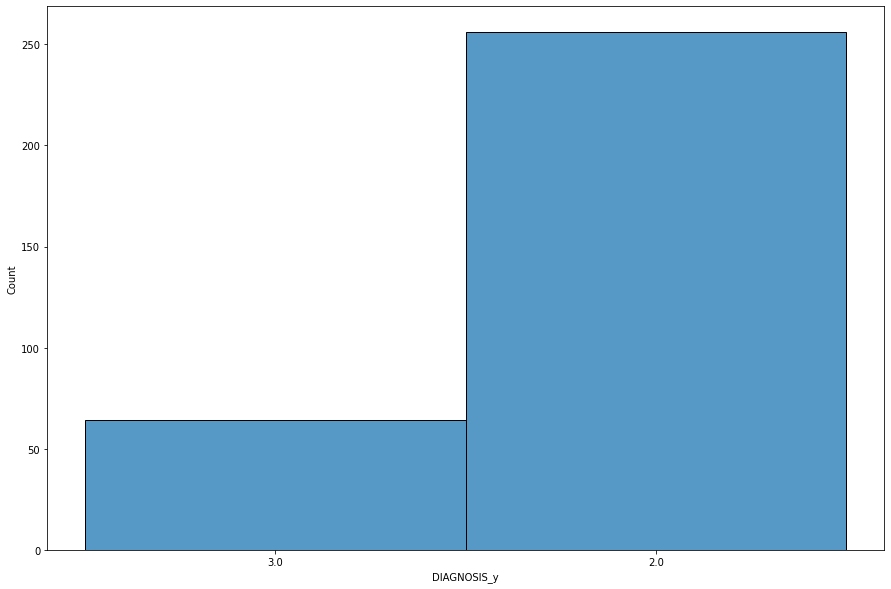

In [301]:
dx_img = dx_img[dx_img["DIAGNOSIS_y"] != 1]
sns.histplot(dx_img["DIAGNOSIS_y"].astype(str))

In [302]:
dx_img.dropna(inplace=True)
Y = dx_img["DIAGNOSIS_y"]
Y[Y==2] = 0
Y[Y==3] = 1

#SITE = dx_img['SITEID']
X = dx_img.drop(["DIAGNOSIS_y"], axis=1)

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, train_size=0.7)

In [349]:

dataset= {'data': np.array(X_train),
          'target': np.array(y_train),
          'name': 'prediction'}

classifiers = [('sklearn.ensemble', 'GradientBoostingClassifier', {}),
              ('sklearn.ensemble', 'RandomForestClassifier', {}),
              ('sklearn.neural_network', 'MLPClassifier', {}),
              ('sklearn.tree', 'DecisionTreeClassifier', {})]

oversamplers = sv.queries.get_all_oversamplers(n_quickest=2)

os_params = sv.queries.generate_parameter_combinations(oversamplers,
                                                      n_max_comb=2)

# samp_obj and cl_obj contain the oversampling and classifier objects which give the
# best performance together
samp_obj, cl_obj= sv.evaluation.model_selection(dataset=dataset,
                                                oversamplers=os_params,
                                                classifiers=classifiers,
                                                validator_params={'n_splits': 2,
                                                                  'n_repeats': 1},
                                                n_jobs= 5)

print(samp_obj)
print(cl_obj)

2023-03-10 18:09:02.342812: processing dataset: prediction
('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
RandomForestClassifier()


In [350]:
X_train_samp, y_train_samp= samp_obj.sample(np.array(X_train),
                                np.array(y_train))

2023-03-10 18:09:12,058:INFO:polynom_fit_SMOTE_star: Running sampling via ('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
2023-03-10 18:09:12,060:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


In [351]:
rus = RandomUnderSampler(random_state=0)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train_samp, y_train_samp)

In [352]:
featureSelector = Lasso( alpha=0.005)
featureSelector.fit(X_train_resampled, y_train_resampled)

Lasso(alpha=0.005)

In [353]:
coefficients = featureSelector.coef_

In [354]:
importance = np.abs(coefficients)

In [355]:
cols = importance != 0
colNames = np.array(TAs[:68])[importance != 0]

In [356]:
X_test = X_test.loc[:,cols].copy()
X_train_resampled = X_train_resampled[:,cols]

In [357]:
models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]

In [358]:
kfold = KFold(n_splits=10)
for model in models:
    cv_results = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kfold, scoring='accuracy', n_jobs=-1)
    print(model, cv_results.sum()/10)

GradientBoostingClassifier() 0.7922794117647058
RandomForestClassifier() 0.7125
SVC() 0.7933823529411764
DecisionTreeClassifier() 0.6091911764705882
MLPClassifier() 0.3900735294117647


In [359]:
param_grid={'n_estimators':[100,500], 
            'learning_rate': [0.1,0.05,0.02],
            'max_depth':[4], 
            'min_samples_leaf':[3], 
            'max_features':[1.0] } 

kfold = KFold(n_splits=10)
rf = GradientBoostingClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_resampled, y_train_resampled)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
0.8047794117647058
{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 500}


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


<Axes: >

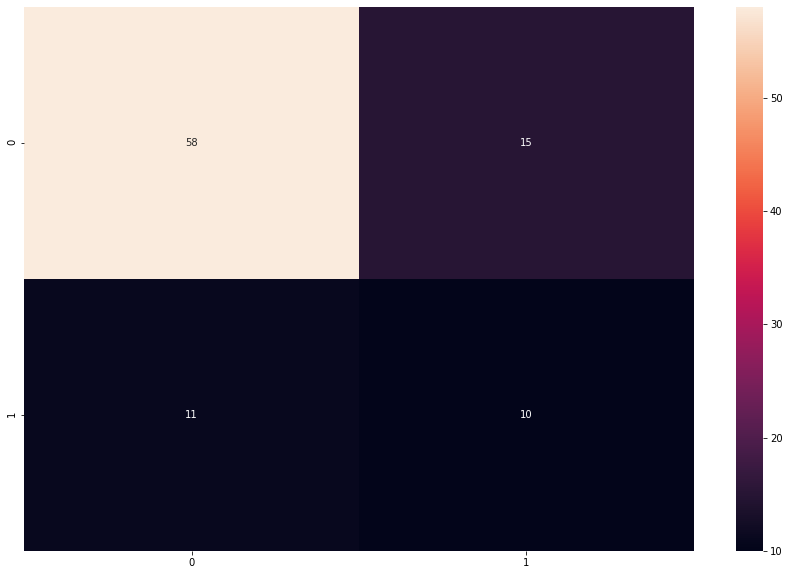

In [360]:
rf = GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=3, n_estimators=500, max_features=1.0, max_depth=4)
rf.fit(X_train_resampled, y_train_resampled)
results = rf.predict(X_test)
x = zip(results, y_test)

# Print the confusion matrix for the model
cf_matrix = sklearn.metrics.confusion_matrix(y_test, results)
sns.heatmap(cf_matrix, annot=True, fmt='g')

In [361]:
accuracy_score(y_test, results)

0.723404255319149

In [362]:
balanced_accuracy_score(y_test, results)

0.6353555120678408

Text(0, 0.5, 'Feature Importance Score')

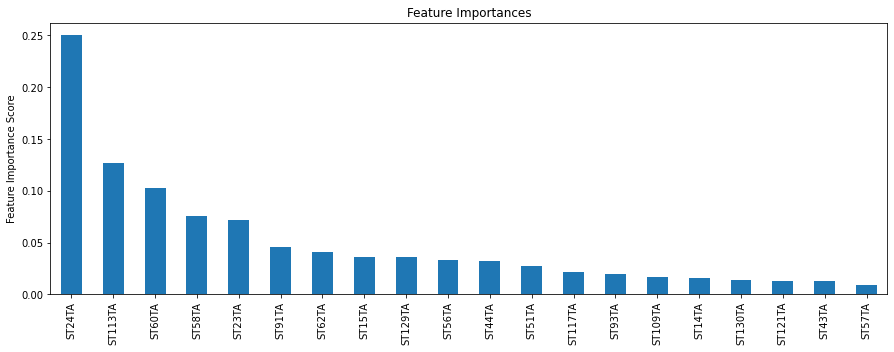

In [346]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
feat_imp = pd.Series(rf.feature_importances_, X_test.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


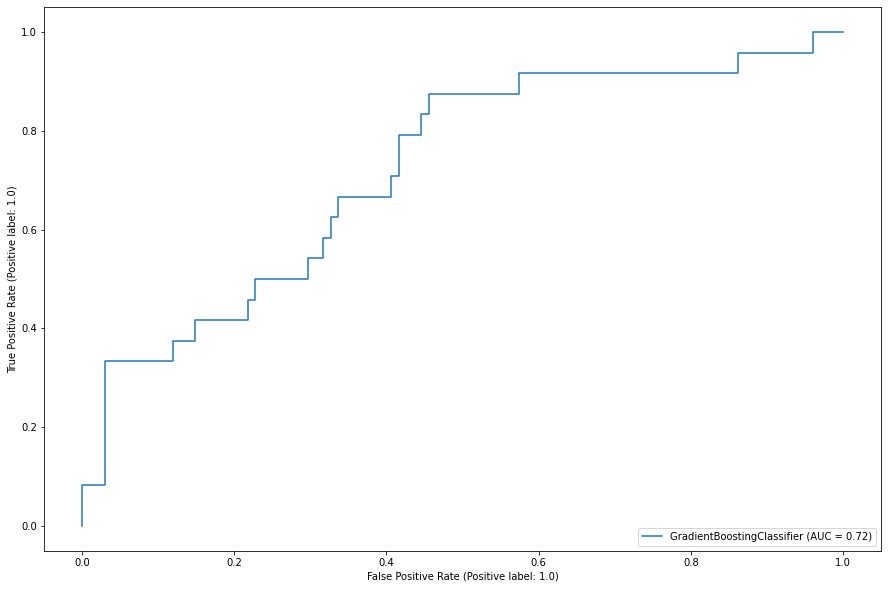

In [347]:
from sklearn.metrics import RocCurveDisplay
plt.rcParams['figure.figsize'] = [15, 10]
svc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)


In [281]:
dt = DecisionTreeClassifier()
dt.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier()

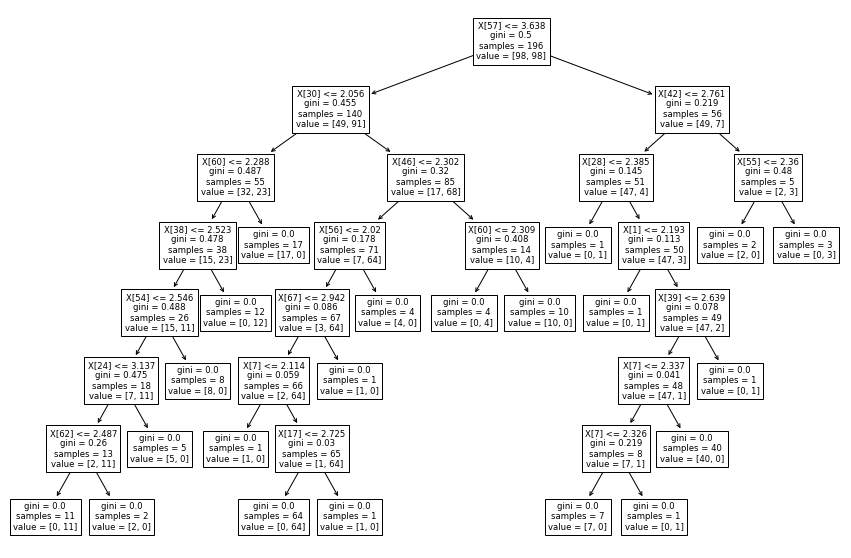

In [150]:
from sklearn.datasets import load_iris
from sklearn import tree

tree.plot_tree(dt)
plt.show()

'ST83TA'